In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

zip_file_path = '/content/drive/MyDrive/colab_files/worksheet_5/FruitinAmazon.zip'
extract_to_path = 'FruitinAmazon'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report


In [4]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


In [5]:
train_dir = "/content/FruitinAmazon/FruitinAmazon/train"

image_size = (224, 224)
batch_size = 32

train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


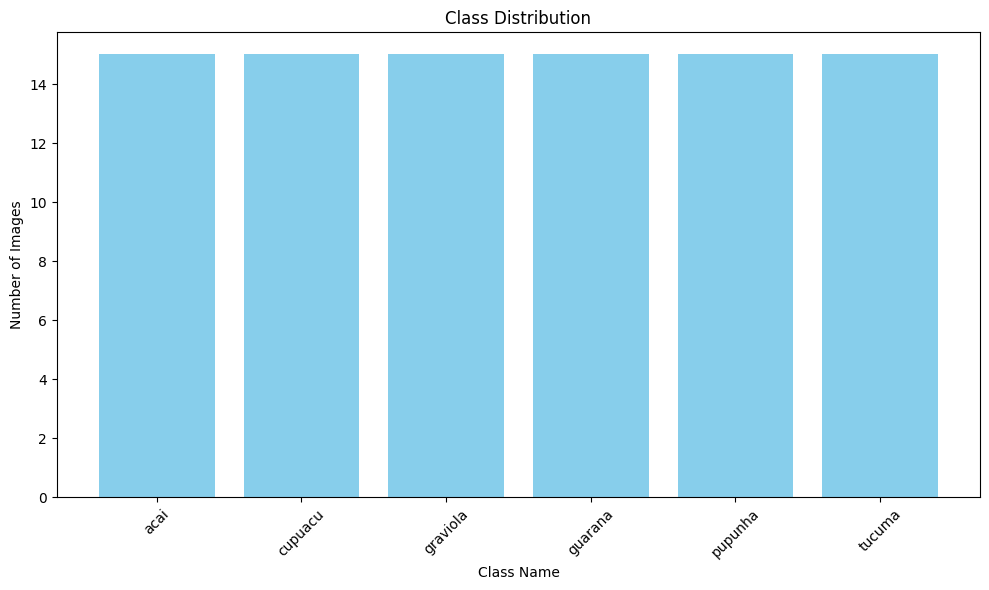

In [6]:
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    count = len([
        img for img in os.listdir(class_path)
        if img.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])
    class_counts[class_name] = count

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Class Distribution")
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
import matplotlib.image as mpimg


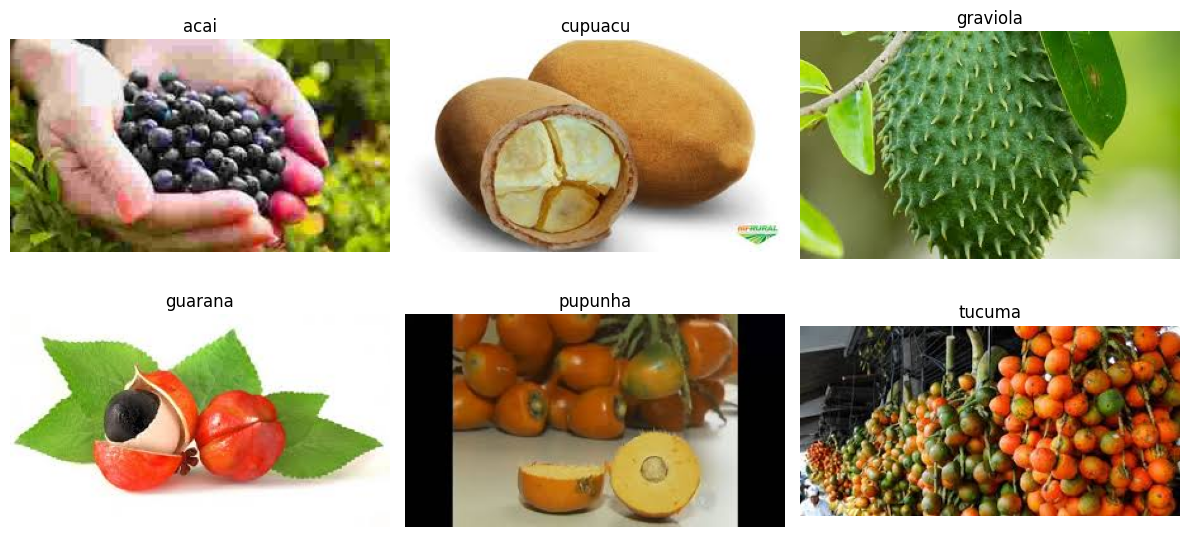

In [9]:
selected_images = []
selected_labels = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    images = [
        img for img in os.listdir(class_path)
        if img.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    if images:
        img_file = random.choice(images)
        selected_images.append(os.path.join(class_path, img_file))
        selected_labels.append(class_name)

fig, axes = plt.subplots(2, (len(selected_images)+1)//2, figsize=(12, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i < len(selected_images):
        img = mpimg.imread(selected_images[i])
        ax.imshow(img)
        ax.set_title(selected_labels[i])
        ax.axis("off")
    else:
        ax.axis("off")
plt.tight_layout()
plt.show()

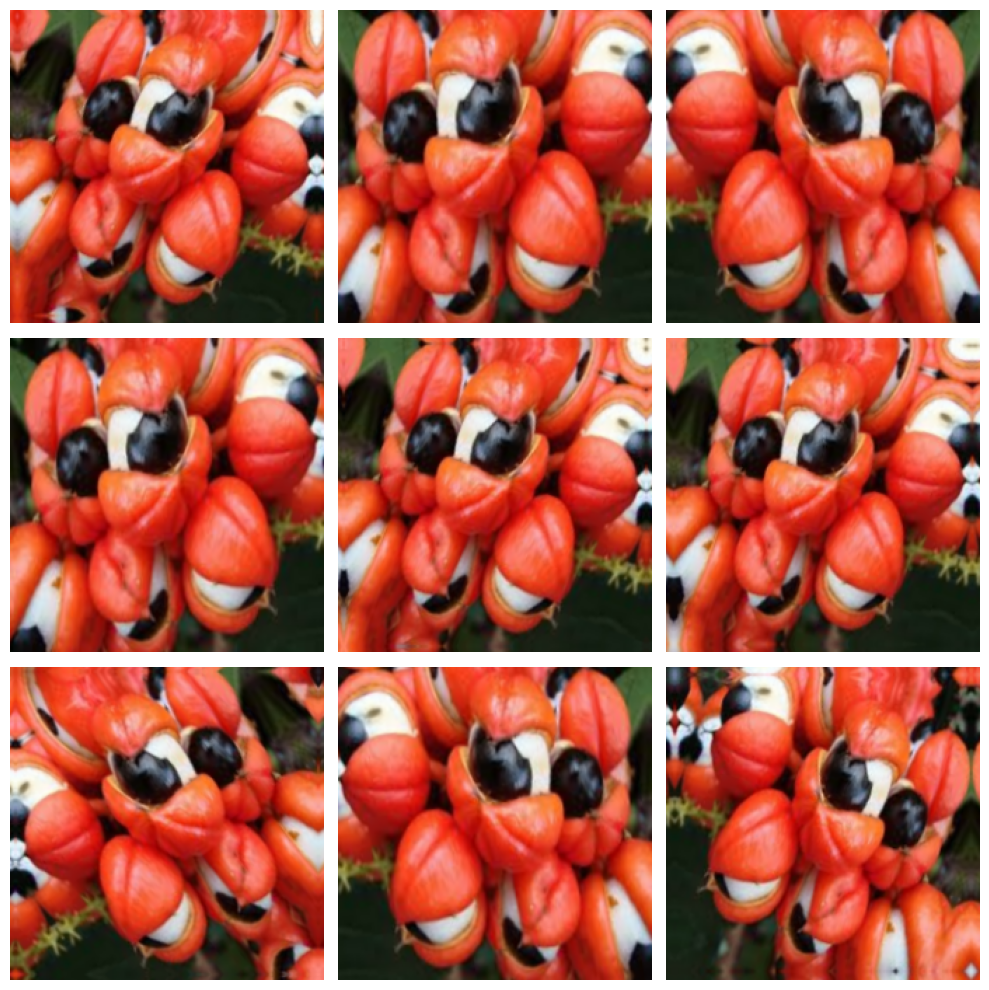

In [12]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_img = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_img[0].numpy().astype("uint8"))
        plt.axis("off")
plt.tight_layout()
plt.show()

In [13]:
model_scratch = Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    layers.Rescaling(1./255),

    # Conv Block 1
    layers.Conv2D(32, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Conv Block 2
    layers.Conv2D(64, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Conv Block 3
    layers.Conv2D(128, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Dense Layers
    layers.Flatten(),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model_scratch.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

model_scratch.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,54

 Total params: 25,787,078 (98.37 MB)

 Trainable params: 25,786,118 (98.37 MB)

 Non-trainable params: 960 (3.75 KB)

In [14]:
history = model_scratch.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 582ms/step - accuracy: 0.2834 - loss: 2.4910 - val_accuracy: 0.1111 - val_loss: 4.1555
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.5295 - loss: 1.6658 - val_accuracy: 0.1667 - val_loss: 1.9229
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.6819 - loss: 0.9852 - val_accuracy: 0.3333 - val_loss: 1.6821
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7361 - loss: 0.7821 - val_accuracy: 0.1111 - val_loss: 1.9224
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.7600 - loss: 0.7325 - val_accuracy: 0.1111 - val_loss: 2.4520
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.7812 - loss: 0.5477 - val_accuracy: 0.1111 - val_loss: 2.8261
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7943 - loss: 0.6048 - val_accuracy: 0.1111 - val_loss: 3.2135
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7951 - loss: 0.5415 - val_accuracy: 0.1111 - val_loss

In [15]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze layers

# Add custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_vgg = Model(inputs=base_model.input, outputs=outputs)

model_vgg.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model_vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,246,150 (58.16 MB)

 Trainable params: 531,462 (2.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
history_vgg = model_vgg.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - accuracy: 0.1871 - loss: 9.4257 - val_accuracy: 0.3333 - val_loss: 5.2705
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 162ms/step - accuracy: 0.4028 - loss: 5.5423 - val_accuracy: 0.5000 - val_loss: 4.6174
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.7726 - loss: 1.4449 - val_accuracy: 0.4444 - val_loss: 3.6420
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.8876 - loss: 0.5136 - val_accuracy: 0.5556 - val_loss: 3.7118
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9036 - loss: 0.4986 - val_accuracy: 0.7222 - val_loss: 2.8911


In [17]:
# Get predictions and true labels
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model_vgg.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
              precision    recall  f1-score   support

        acai       1.00      1.00      1.00         1
     cupuacu       0.33      0.50      0.40         2
    graviola       0.75      1.00      0.86         3
     guarana       0.80      0.80      0.80         5
     pupunha       0.67      0.50      0.57         4
      tucuma       1.00      0.67      0.80         3

    accuracy                           0.72        18
   macro avg       0.76      0.74      0.74        18
weighted avg       0.75      0.72      0.73        18



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


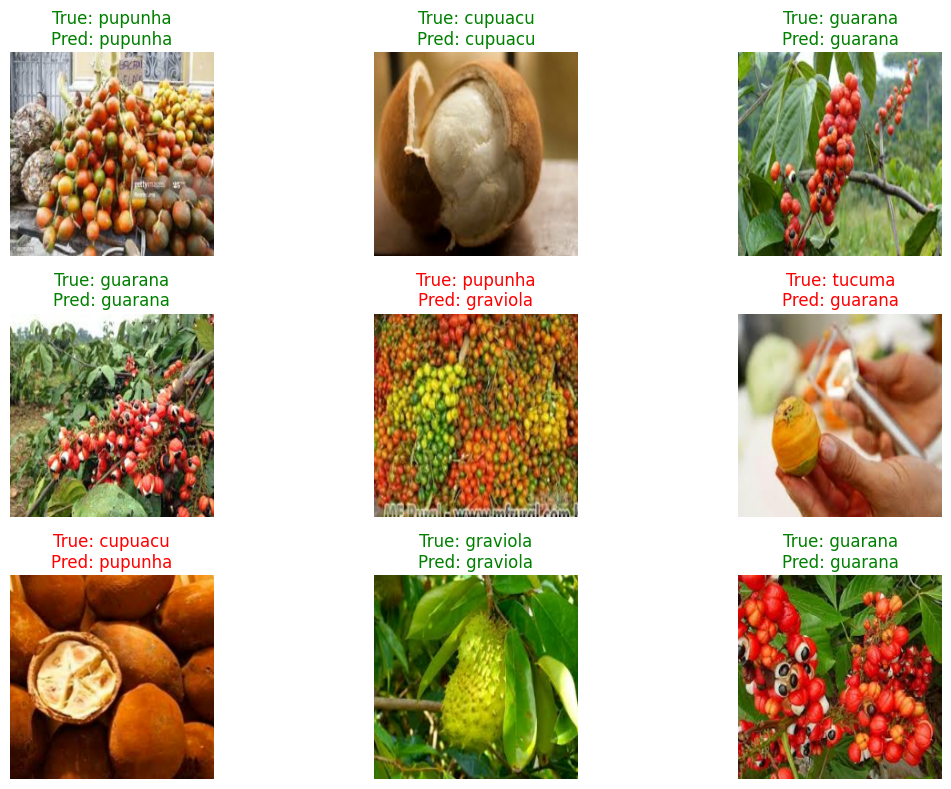

In [18]:
model_to_visualize = model_vgg  # or model_scratch

for images, labels in val_ds.take(1):
    preds = model_to_visualize.predict(images)
    predicted_labels = np.argmax(preds, axis=1)
    true_labels = labels.numpy()
    break

plt.figure(figsize=(12, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    true_label = class_names[true_labels[i]]
    pred_label = class_names[predicted_labels[i]]
    color = "green" if true_label == pred_label else "red"
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis("off")
plt.tight_layout()
plt.show()